# Use bloomberg download data to get me started

In [221]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [222]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [224]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Reported EPS','Comp EPS','Consensus EPS','50d MA','3d return','3d rel return','Volume','Momentum',
             'Revision','Market cap','PE','Property','Price']

data_dict={}

for s in tabs_to_grab:
    data_dict[s]=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2016-2018.xlsx',sheet_name=s))

## Signal 1 - absolute signal

In [297]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(data_df,return_df, return_criteria,revision_df, revision_criteria):
    signal1_evaluate=(return_df>return_criteria) & (revision_df>revision_criteria)
    signal1=data_df[signal1_evaluate].dropna(axis=1,how='all').dropna(axis=0,how='all')
    return signal1

abs_signal1=signal1_formation(data_dict['Date'],data_dict['3d return'],2,data_dict['Revision'],0.02)
rel_signal1=signal1_formation(data_dict['Date'],data_dict['3d rel return'],2,data_dict['Revision'],0.02)

In [319]:
#Stack signals into a list of tuples (stocks, dates), convert dates into a common format of datetime
def signal1_stacking(signal1):
    signal1_list=[]
    for index, row in signal1.iterrows():
        adj_row=row.dropna()
        for s in adj_row.values:
            ts=(s - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's') 
            adj_time=datetime.utcfromtimestamp(ts).strftime("%d/%b/%Y") #transform the datetime into a common format
            signal1_list.append((adj_row.name,adj_time))
    return signal1_list

signal1_abs_list=signal1_stacking(abs_signal1)
signal1_rel_list=signal1_stacking(rel_signal1)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  import sys


In [325]:
# grab the price time series and transform it into the same datetime format; also generate abs_return, rel_return dataframe
price=data_dict["Price"].dropna(axis=1, how='all').dropna(axis=0,how='all')
new_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
price.columns=new_column

abs_return=price.diff(1,axis=1)/price
abs_return=abs_return.dropna(how='all',axis=1)
rel_return=abs_return - abs_return.iloc[-1]
rel_return=rel_return.dropna(how='all',axis=1)

In [326]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_return_dict(signal1_list,return_dataframe,holding):
    signal1_dict={}
    for s in signal1_list:
        return_series=return_dataframe.loc[s[0]]
        if s[1] in return_series.index:          
            day0=return_series.index.tolist().index(s[1]) #index of day 0
        else:
            pass
        target_series=return_series.iloc[day0:day0+min(holding, len(return_series[day0:]))]
        target_series.index=range(min(holding, len(return_series[day0:]))) #replace datetime with number of days post announcement
        target_series.name=s
        signal1_dict[s]=target_series
    return signal1_dict

In [331]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_return_df(signal1_list,return_dataframe,holding):
    return_series_list=[]
    return_dict=signal1_return_dict(signal1_list,return_dataframe,holding)
    for index,key in return_dict.items():
        return_series_list.append(key)
    return_df=pd.concat(return_series_list,axis=1)
    return_df=return_df.dropna(how='any',axis=1) #drop stocks with limited history to make it more comparable
    return return_df

abs_signal1_abs_return_df=signal1_return_df(signal1_abs_list,abs_return,130)
abs_signal1_rel_return_df=signal1_return_df(signal1_abs_list,rel_return,130)
rel_signal1_abs_return_df=signal1_return_df(signal1_rel_list,abs_return,130)
rel_signal1_rel_return_df=signal1_return_df(signal1_rel_list,rel_return,130)


In [341]:
# List of signals and cumulative returns
abs_signal1_ind_abs_return=abs_signal1_abs_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
abs_signal1_ind_abs_return

abs_signal1_ind_rel_return=abs_signal1_rel_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
abs_signal1_ind_rel_return

rel_signal1_ind_abs_return=rel_signal1_abs_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
rel_signal1_ind_abs_return

rel_signal1_ind_rel_return=rel_signal1_rel_return_df.iloc[3:].cumsum(axis=0).iloc[-1]
rel_signal1_ind_rel_return

CPR IM    09/May/2017    0.100089
          01/Mar/2016    0.232640
RF FP     17/Mar/2017    0.201175
GKN LN    28/Feb/2017   -0.155858
GLE FP    03/Nov/2016    0.157413
          03/Aug/2016    0.308336
STB NO    13/Jul/2017    0.045827
          27/Apr/2016    0.232679
WPP LN    24/Aug/2016   -0.043455
REP SM    27/Jul/2017    0.047773
FLS DC    09/Feb/2017    0.023923
LNZ AV    22/Mar/2017   -0.292174
          24/Aug/2016    0.247644
          12/May/2016    0.379304
HAS LN    31/Aug/2017    0.030586
ANTO LN   14/Mar/2017    0.171179
          16/Aug/2016    0.322655
PNN LN    24/May/2017   -0.187901
ORK NO    15/Jul/2016   -0.086248
          03/May/2016    0.036665
SIK SW    24/Feb/2017    0.160299
          29/Jul/2016    0.010873
TEN IM    03/Nov/2016   -0.080987
DNO NO    11/Feb/2016    0.128388
LIN GR    28/Oct/2016   -0.058264
FI/N SW   19/Jul/2017    0.196471
SCAB SS   27/Oct/2016   -0.012072
LDO IM    15/Mar/2017    0.066018
          28/Jul/2016    0.177133
EDF FP    29/J

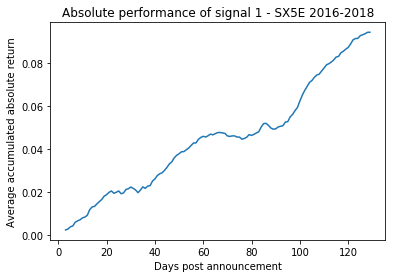

In [343]:
# Performance analytics
# 1. aggregate abs/rel performance over time
def perf_chart(return_df,xlabel,ylabel,title):
    cum_return=return_df.mean(axis=1).cumsum()
    plt.plot(cum_return)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    
perf_chart(abs_signal1_abs_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated absolute return",title="Absolute performance of signal 1 - SX5E 2016-2018")

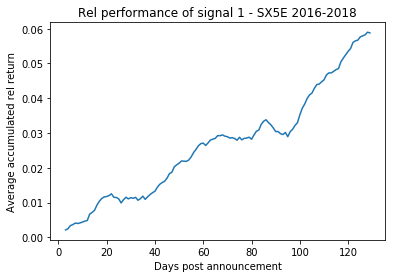

In [345]:
perf_chart(abs_signal1_rel_return_df.iloc[3:], xlabel="Days post announcement",
           ylabel="Average accumulated rel return",title="Rel performance of signal 1 - SX5E 2016-2018")


In [250]:
# 2. trading analytics
def trading_analytics(return_df):
    ind_return=return_df.cumsum(axis=0).iloc[-1]
    signal1_count=len(ind_return)
    hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
    payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
    #annualised_return=return_df.mean(axis=1).cumsum().iloc[-1]*260/(len(return_df))
    #annualised_vol=return_df.mean(axis=1).std()*((260/(len(return_df)))**0.5)
    #annualised_sharpe=annualised_return/annualised_vol*1.0
    return signal1_count, hit_rate,payoff_ratio
    
trading_analytics(rel_return_df[3:]) 


(554, 0.6498194945848376, 1.3600545261759656)

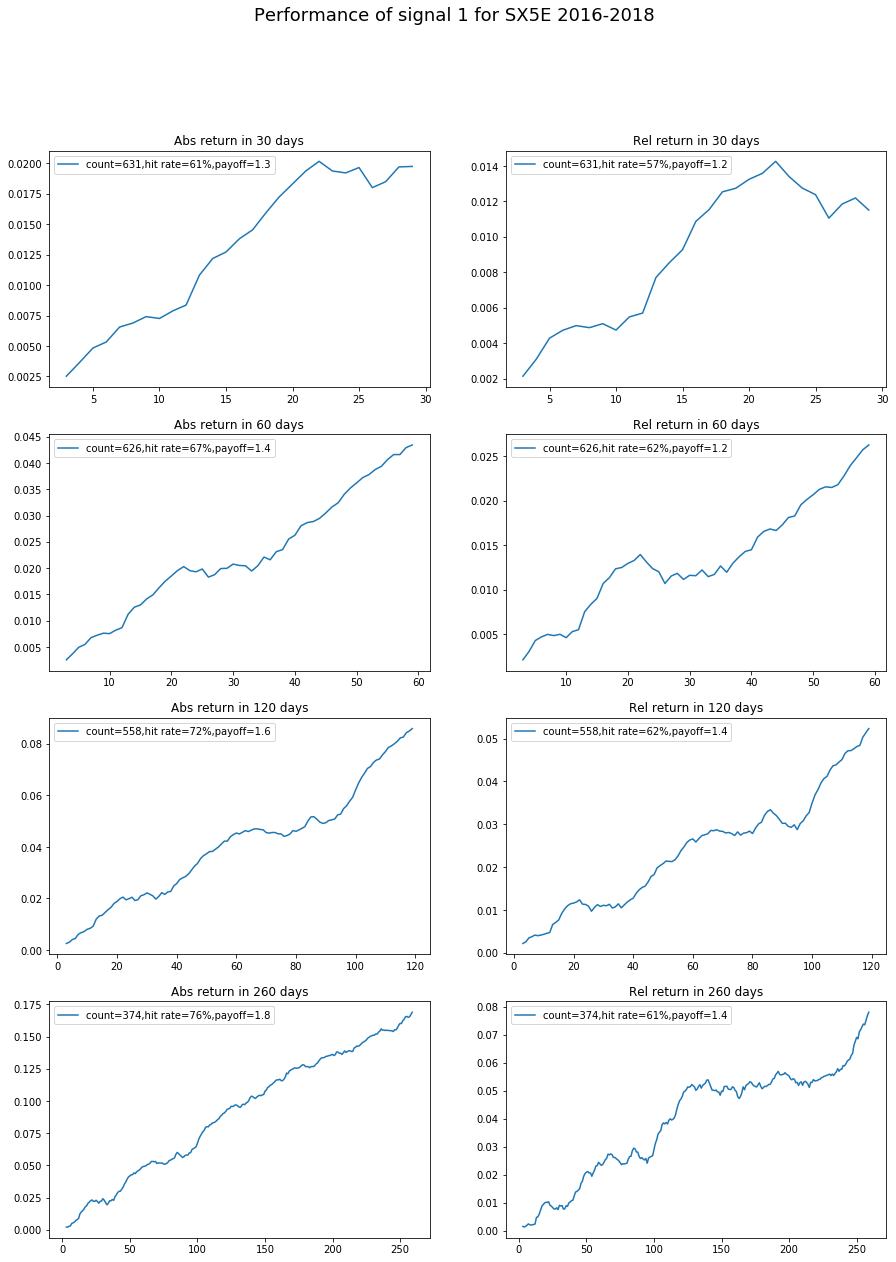

In [251]:
# plot the performance for different holding period 
def multiple_plot(period_list,figsize,fontsize,title,signal1_list,abs_return,rel_return):    
    period_list=[30,60,120,260]
    fig=plt.figure(figsize=figsize)
    fig.suptitle("Performance of signal 1 for Europe 2016-2018", fontsize=fontsize)
    for idx, val in enumerate(period_list):
        ax1=fig.add_subplot(len(period_list),2,idx*2+1)
        abs_return_df=signal1_return_df(signal1_list,abs_return,val)
        abs_cum_return=abs_return_df[3:].mean(axis=1).cumsum()
        ax1.plot(abs_cum_return)
        ax1.set_title("Abs return in "+str(val)+" days")
        count,hit, payoff=trading_analytics(abs_return_df[3:])
        ax1.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,1))])

        ax2=fig.add_subplot(len(period_list),2,idx*2+2)
        rel_return_df=signal1_return_df(signal1_list,rel_return,val)
        rel_cum_return=rel_return_df[3:].mean(axis=1).cumsum()
        ax2.plot(rel_cum_return)
        ax2.set_title("Rel return in "+str(val)+" days")
        count,hit, payoff=trading_analytics(rel_return_df[3:])
        ax2.legend(['count='+str(count)+
                    ',hit rate='+str("{:.0%}".format(hit))+
                    ',payoff='+str(round(payoff,1))])
    plt.show()

    
multiple_plot([30,60,120,260],(15,20),18,"Performance of signal 1 for Europe 2016-2018",signal1_list,abs_return,rel_return)